<a href="https://colab.research.google.com/github/sedavasema/Mask-RCNN-for-cell-nucleus/blob/main/mask_RCNN_cell_nucleus_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R-CNN - Train cell nucleus Dataset


This notebook shows how to train Mask R-CNN implemented on coco on your own dataset. I trained the model to segment cell nucleus objects in an image. You'd need a GPU, because the network backbone is a Resnet101, which would be too slow to train on a CPU.The code is execuatble on google colaboratory GPU.  On google colab you can start to get okay-ish results in a few minutes, and good results in less than an hour.



In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

#downloading dataset from github 
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

!mkdir stage1_train stage1_test

!unzip stage1_train.zip -d stage1_train/
!unzip stage1_test.zip -d stage1_test/

# Data Path
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

print("Please upload the config.py to your google colab")
from google.colab import files
src = list(files.upload().values())[0]
open('config.py','wb').write(src)
import config

print("Please upload the utils.py to your google colab")
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
import utils

Streaming output truncated to the last 5000 lines.
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d8b76279ad8f2e101bb8c5ca95229b6532903eea035ef945dd4a21356d49dead.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/dc05f946c096c5fcc147024843f21c06c3a94af25d4f37b498ea937953b806fe.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e0fd1c4e98bb470bea315e7d8f74396450fe93e93f68e1f8a3443b2b397c8640.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e4b6643cafde8ac789b63f7b1a023773960dbe63489963985033619fde052dc9.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e7e793a1e1785a41a0432a6cd2137be6e1a448bce9f343cfecb493c699206f82.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e893bbfe02a7

Saving config.py to config.py
Please upload the utils.py to your google colab


Saving utils.py to utils.py


In [2]:
print("Please upload the model.py to your google colab")
from google.colab import files
src = list(files.upload().values())[0]
open('model.py','wb').write(src)
import model

Please upload the model.py to your google colab


Saving model.py to model.py


/content/model.py:2228: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':


In [3]:
print("Please upload the visualize.py to your google colab")
from google.colab import files
src = list(files.upload().values())[0]
open('visualize.py','wb').write(src)
import visualize

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Please upload the visualize.py to your google colab


Saving visualize.py to visualize.py
... done downloading pretrained model!


## Configurations

In [4]:
class ShapesConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleus

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 896
    IMAGE_MAX_DIM = 896

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 800

    # set number of epoch
    STEPS_PER_EPOCH = 200

    # set validation steps 
    VALIDATION_STEPS = 50
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[224 224]
 [112 112]
 [ 56  56]
 [ 28  28]
 [ 14  14]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  896
IMAGE_MIN_DIM                  896
IMAGE_PADDING                  True
IMAGE_SHAPE                    [896 896   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE  

## Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [6]:
class ShapesDataset(utils.Dataset):
    
    def load_shapes(self, mode):
        
        # Add classes
        self.add_class("shapes", 1, "nucleus")
        

        if mode == "train":  
            for n, id_ in enumerate(train_ids):
                if n < int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)
              
        if mode == "val":   
            for n, id_ in enumerate(train_ids):
                if n >= int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)      

    def load_image(self, image_id):
        
        info = self.image_info[image_id]
        info = info.get("id")
       
        path = TRAIN_PATH + info
        img = imread(path + '/images/' + info + '.png')[:,:,:3]
        img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
       
        return img

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        
        info = self.image_info[image_id]
        info = info.get("id")
        path = TRAIN_PATH + info
        number_of_masks = len(next(os.walk(path + '/masks/'))[2])
        mask = np.zeros([config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], number_of_masks], dtype=np.uint8)
        iterator = 0
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = resize(mask_, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
            mask[:, :, iterator] = mask_
            iterator += 1
            # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(number_of_masks-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
            
        # Map class names to class IDs.
        class_ids = np.ones((number_of_masks,), dtype=int)
        
        return mask, class_ids.astype(np.int32)
         
       
        

In [7]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes("train")
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes("val")
dataset_val.prepare()

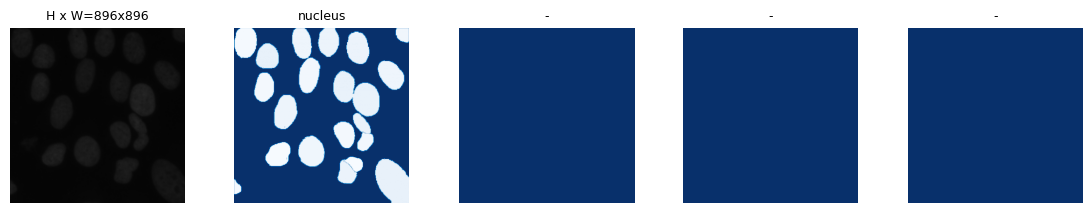

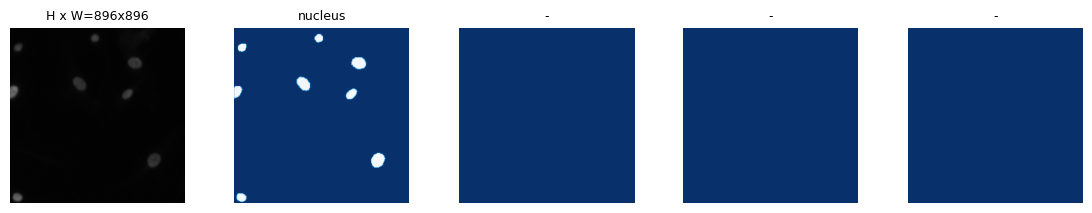

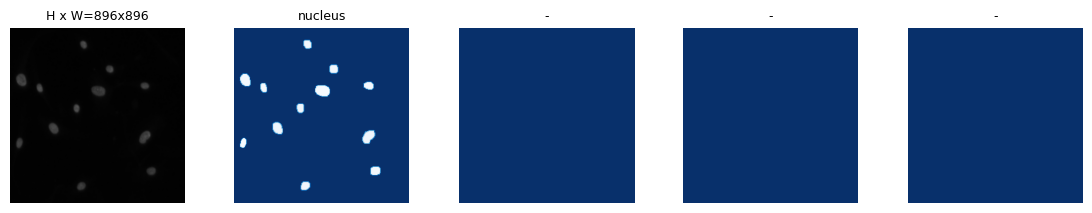

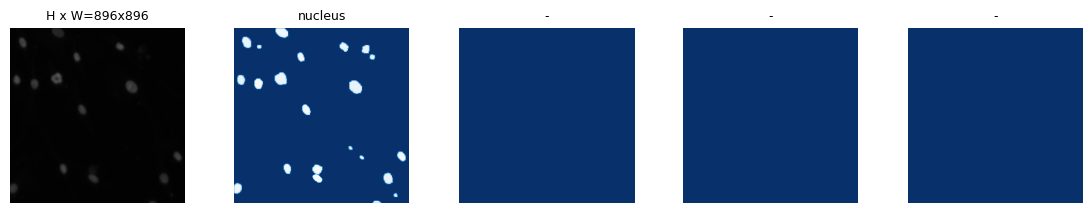

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [10]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [26]:
import utils
import model as modellib

In [14]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,model_dir=MODEL_DIR)

ValueError: ignored

In [12]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

AttributeError: ignored

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/shapes20180801T0833/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicat

Epoch 1/1
200/200 [==============================] - 910s 5s/step - loss: 1.6857 - rpn_class_loss: 0.1791 - rpn_bbox_loss: 0.7052 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.3544 - mrcnn_mask_loss: 0.3371 - val_loss: 0.4954 - val_rpn_class_loss: 0.0356 - val_rpn_bbox_loss: 0.1930 - val_mrcnn_class_loss: 0.0125 - val_mrcnn_bbox_loss: 0.1555 - val_mrcnn_mask_loss: 0.0988


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
"""model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")"""

'model.train(dataset_train, dataset_val, \n            learning_rate=config.LEARNING_RATE / 10,\n            epochs=2, \n            layers="all")'

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes3.h5")
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/logs/shapes20180801T0833/mask_rcnn_shapes_0001.h5


original_image           shape: (896, 896, 3)         min:    0.90816  max:  229.82143
image_meta               shape: (10,)                 min:    0.00000  max:  896.00000
gt_class_id              shape: (12,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (12, 4)               min:    4.00000  max:  896.00000
gt_mask                  shape: (896, 896, 12)        min:    0.00000  max:  255.00000


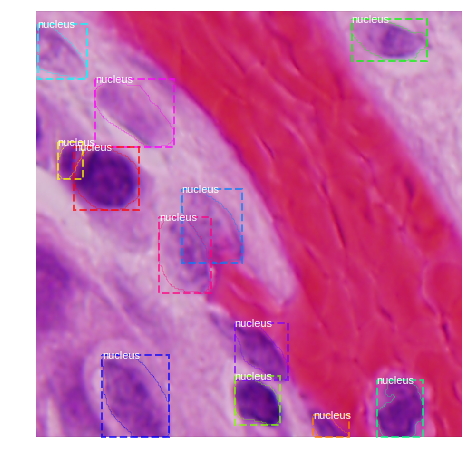

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (896, 896, 3)         min:    0.90816  max:  229.82143
molded_images            shape: (1, 896, 896, 3)      min: -115.89184  max:  119.38827
image_metas              shape: (1, 10)               min:    0.00000  max:  896.00000


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


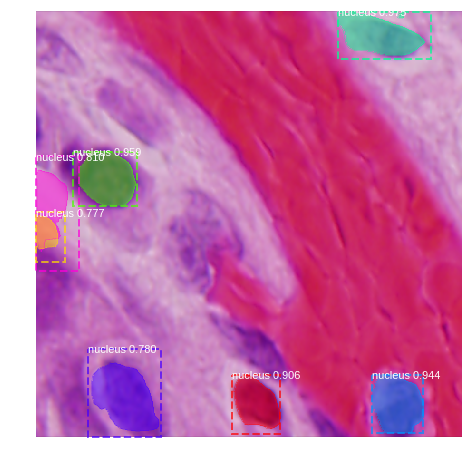

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 30 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 30)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


mAP:  0.6949634079498883
finish


In [ ]:

X_test = np.zeros((len(test_ids), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
sizes_test = []
_test_ids = []

print('Getting and resizing test images ... ')
#sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    _test_ids.append([id_])
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


checking a test image with masks ...
Processing 1 images
image                    shape: (896, 896, 3)         min:    1.00000  max:   94.00000
molded_images            shape: (1, 896, 896, 3)      min: -122.70000  max:   -9.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  896.00000


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


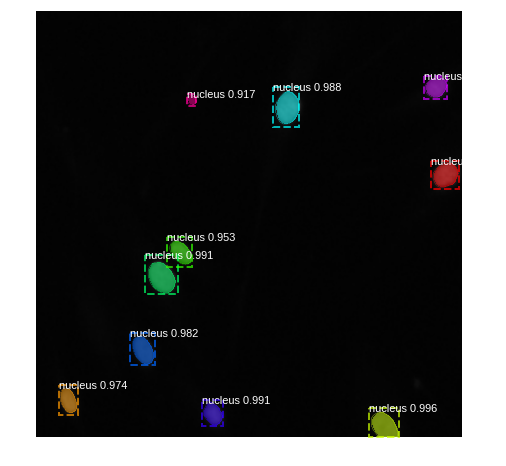

In [ ]:
print("checking a test image with masks ...")
results = model.detect([X_test[7]], verbose=1)

r = results[0]
visualize.display_instances(X_test[7], r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())


In [ ]:
# Run-length encoding for submission
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
  
  
def prob_to_rles(x):
   
    for i in range(0, len(x[1, 1, :])):
        y = x[:, :, i]
        yield rle_encoding(np.squeeze(y))

new_test_ids = []
rles = []

print(len(test_ids))

for n in range(0, len(test_ids)):

    results = model.detect([X_test[n]], verbose=0)
     
    r = results[0]

    number_of_masks = len(r['masks'][1, 1, :])
    
    pred_masks = np.zeros([sizes_test[n][0], sizes_test[n][1], number_of_masks], dtype=np.uint8)
   
    for m in range(0, number_of_masks):
        pred_mask_temp = r['masks'][:, :, m]
        pred_masks[:, :, m] = resize(np.squeeze(pred_mask_temp), (sizes_test[n][0], sizes_test[n][1]), mode='constant', preserve_range=True)
        
    # Handle occlusions
    occlusion = np.logical_not(pred_masks[:, :, -1]).astype(np.uint8)
    for i in range(number_of_masks-2, -1, -1):
        pred_masks[:, :, i] = pred_masks[:, :, i] * occlusion
        occlusion = np.logical_and(occlusion, np.logical_not(pred_masks[:, :, i]))
        
    rle = list(prob_to_rles(pred_masks))
        
            
    em = 0
    while (em < len(rle)):
          if len(rle[em]) == 1:
              print ("mask has one pixel")
          if len(rle[em]) == 0:
              print ("mask is empty. deleting mask")
              del rle[em]
          else:
              em = em + 1
    
    
    k = 0
    
    for m in range(0, len(rle)):
        while (k < len(rle[m]) ):
            if rle[m][k] + rle[m][k+1] >= sizes_test[n][0] * sizes_test[n][1]:
                print("Index was outside the bounds of the array.    index = ", rle[m][k] + rle[m][k+1], "    array size = ", sizes_test[n][0] * sizes_test[n][1] )
                rle[m][k+1] = sizes_test[n][0] * sizes_test[n][1] - rle[m][k] - 1
                #print("run length fixed ")
                print("run length fixed.    index = ", rle[m][k] + rle[m][k+1], "    array size = ", sizes_test[n][0] * sizes_test[n][1] )
                if rle[m][k+1] < 0:
                    print("run lngth is negative. deleting the index and run length   ")
                    del rle[m][k]
                    del rle[m][k]
                if rle[m][k] < 0:
                    print("index is negative. deleting the index and run length   ")
                    del rle[m][k]
                    del rle[m][k]
                    
           
                    
                 
                    
                #check that pixels are ordered 
                if rle[m][k] > rle[m][k+2]:
                   print ("pixel not ordered")
                
                #check that a pixel is not duplicated
                if rle[m][k] + rle[m][k+1] >= rle[m][k+2]:
                   print ("pixel duplicated")
                
            k = k + 2
    k = 0           
    for m in range(0, len(rle)):
        
        while (k < len(rle[m]) ):
            if rle[m][k] + rle[m][k+1] >= sizes_test[n][0] * sizes_test[n][1]:
                print("Index was outside the bounds of the array.    index = ", rle[m][k] + rle[m][k+1], "    array size = ", sizes_test[n][0] * sizes_test[n][1] )
            k = k + 2   
    
    rles.extend(rle)
    new_test_ids.extend(_test_ids[n] * len(rle))


# Create submission DataFrame

sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018.csv', index=False)

    

65


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask
mask is empty. deleting mask


In [ ]:
files.download('sub-dsbowl2018.csv')